<a href="https://colab.research.google.com/github/minhphuoc0910/machine-learning/blob/main/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark py4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=d32a05b545e1ef04eddec72e59089e6bd91f5dd37e1f29f3bfdb8525f685bc01
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, col, lag, month
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.window import Window
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

class PredictStockPrice:
  def __init__(self, file_path, k):
    self.spark = SparkSession.builder.appName("PredictStockPrice").getOrCreate()
    self.data = self.process_data(file_path)
    self.k = k

  def process_data(self,file_path):
    data = self.spark.read.csv(file_path, header=True, inferSchema=True)
    data = data.withColumn("HVN", col("HVN").cast("double"))
    data = data.withColumn("Ngay", to_date("Ngay","dd/MM/yyyy"))

    return data

  def generate_train_test_data(self):
    data_k_days = self.data.select("*")
    # Sử dụng hàm lag để tạo cột với giá của k ngày trước
    for i in range(1, self.k+1):
      data_k_days = data_k_days.withColumn(f"{i} days before", lag("HVN", i).over(Window.orderBy("Ngay")))

    # Loại bỏ hàng có giá null sau khi sử dụng lag
    data_k_days = data_k_days.na.drop()

    # Tạo vector từ giá của k ngày trước
    assembler = VectorAssembler(inputCols=[f"{i} days before" for i in range(1, self.k+1)], outputCol="Price k days before")
    data_k_days = assembler.transform(data_k_days)

    #Chia tập dữ liệu thành 2 phần trước tháng 7 và từ tháng 7 trở đi
    data_from_july = data_k_days.filter(month(col("Ngay")) >= 7)
    data_before_july = data_k_days.filter(month(col("Ngay")) < 7)

    #Lọc lấy vector giá k ngày trước và giá ngày hiện tại
    test_data = data_from_july.select(["Price k days before", "HVN"])
    train_data = data_before_july.select(["Price k days before", "HVN"])

    return test_data, train_data

  def predict(self):
    test_data, train_data = self.generate_train_test_data()
    lr = LinearRegression(featuresCol="Price k days before", labelCol="HVN")
    model = lr.fit(train_data)
    predictions = model.transform(test_data)

    return predictions

  def evaluate(self):
    evaluator = RegressionEvaluator(labelCol="HVN", predictionCol='prediction', metricName='mse')
    mse = evaluator.evaluate(self.predict())

    return mse

In [ ]:
file_path = 'stockHVN2022.csv'

In [ ]:
predict_5 = PredictStockPrice(file_path,5)
predict_5.predict()
mse_5 = predict_5.evaluate()

In [ ]:
predict_6 = PredictStockPrice(file_path,6)
predict_6.predict()
mse_6 = predict_6.evaluate()

In [ ]:
predict_7 = PredictStockPrice(file_path,7)
predict_7.predict()
mse_7 = predict_7.evaluate()

In [ ]:
predict_8 = PredictStockPrice(file_path,8)
predict_8.predict()
mse_8 = predict_8.evaluate()

In [ ]:
predict_9 = PredictStockPrice(file_path,9)
predict_9.predict()
mse_9 = predict_9.evaluate()

In [ ]:
predict_10 = PredictStockPrice(file_path,10)
predict_10.predict()
mse_10 = predict_10.evaluate()

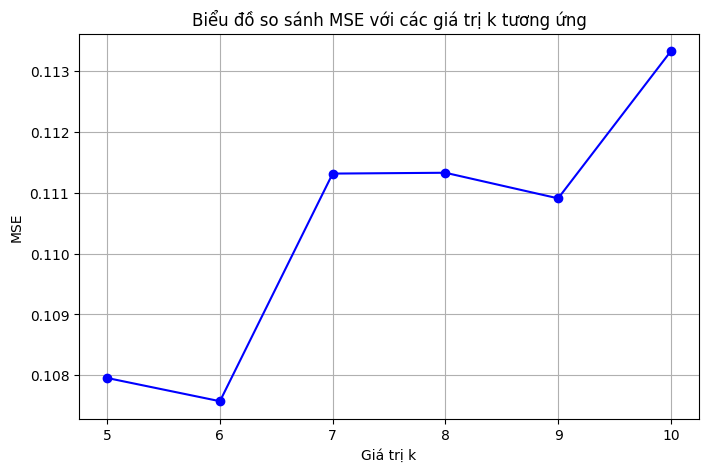

In [ ]:
import matplotlib.pyplot as plt

# Danh sách các giá trị k và tương ứng với MSE
k_values = [5, 6, 7, 8, 9, 10]
mse_values = [mse_5, mse_6, mse_7, mse_8, mse_9, mse_10]

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(k_values, mse_values, marker='o', linestyle='-', color='b')
plt.xlabel("Giá trị k")
plt.ylabel("MSE")
plt.title("Biểu đồ so sánh MSE với các giá trị k tương ứng")
plt.grid(True)
plt.show()


In [ ]:
for mse in mse_values:
  print(mse)

0.10795333147951046
0.10757138049157143
0.11131411407092913
0.11132771598823767
0.11090675296083725
0.11332598687141665
